In [133]:
from catboost import CatBoostClassifier, Pool
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from xgboost import XGBClassifier, DMatrix, plot_importance, plot_tree
from lightgbm import LGBMClassifier, Dataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [267]:
catboost_params = {
    "iterations": 2000,
    "depth": 1,
    "learning_rate": 0.07,
    "loss_function": "Logloss",
    "verbose": False,
    "eval_metric": 'AUC',
    "od_type": 'Iter',
    "od_wait": 300,
}

lr_params = {
    "C": 1.5,
    "fit_intercept": True,
    "max_iter": 300,
    "penalty": "l1",
    "random_state": 123,
    "solver": "liblinear"
}

catboost_columns = [
    'term',
    'acc_open_past_24mths', # 677 02
    'funded_amnt',
    'percent_per_year',
    'additional_dti', #671
    'num_accts_ever_120_pd',
    'annual_inc', # 682 024,
    'tot_hi_cred_lim',
    'purpose', # 6839 035
    'home_ownership', # 683 027
    'avg_cur_bal', # 684 041
    'mths_since_recent_inq',
    'installment',
    
]

catboost_cat_features = [
    'purpose',
    'home_ownership',
]

lr_cols = [   
#     'percent_per_year',
    'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    'installment',
    'is_first_loan',
    'avg_cur_bal',   
]

lgbm_params = {
    'objective': 'binary',
    'max_depth': 1,
    'learning_rate': 0.05,
    'lambda_l2': 0.01,
    'seed': 17,
    'n_estimators': 1000,
    'min_child_weight': 40,
}

knn_params = {
    "n_neighbors": 130,
    "weights": 'distance',
}

knn_columns = [
    'percent_per_year',
#     'percent',
    'term',
    'loan_income_ratio',
    'psk',
    'additional_dti',
    
    'purpose_small_business',
    'purpose_home_improvement',
    'purpose_major_purchase',
    'purpose_medical',
    'purpose_vacation',
    'purpose_wedding',
    'purpose_car',
    
    'acc_open_past_24mths',
    'num_accts_ever_120_pd',
    
    'home_ownership_MORTGAGE',
    'home_ownership_RENT',
    
    'installment',
    'is_first_loan',
    'avg_cur_bal',
    'is_emp_length_unknown',
    'even_salary',
]

lgbm_columns = [
    'percent',
    'acc_open_past_24mths',
    'avg_cur_bal',
    'loan_income_ratio',
    'annual_inc',
    'tot_hi_cred_lim',
    'additional_dti',
    'percent_per_year',
    'purpose',
    'dti',
    'home_ownership',
    'num_accts_ever_120_pd',
    'psk',
    'is_emp_length_unknown',
    'funded_amnt',
]

lgbm_cat_features = [
    'purpose',
    'home_ownership',
]

xgb_columns = [   
    'dti',
    'inq_last_6mths',
    'mths_since_recent_inq',
    'num_accts_ever_120_pd',
    'acc_open_past_24mths',
    'tot_hi_cred_lim',
    'purpose',
    'home_ownership',
    'psk',
    'percent',
    'loan_income_ratio',
    'is_emp_length_unknown',
    'funded_amnt_mod_100',   
]


xgb_params = {
    'max_depth': 1,
    'learning_rate': 0.1,
    'reg_alpha': 1,
    'reg_lambda': 10,
    'n_estimators': 1500,
}

nb_columns = [
    'percent',
    'annual_inc',
    'purpose_small_business',
    'percent_per_year',
    'additional_dti', 
    'avg_cur_bal_log',
]

bnb_columns = [
    'loan_income_ratio',
    'annual_inc_log',
    'percent',
    'home_ownership_RENT',
    'inq_last_6mths',
    'tot_hi_cred_lim',
    'is_first_loan',
    'num_accts_ever_120_pd',
    'term',
    'purpose_small_business',
    'acc_open_past_24mths',
    'home_ownership_MORTGAGE',
]

rf_columns = [
    'residual_dti',
    'tot_hi_cred_lim_annual_inc_ratio',
    'funded_amnt',
    'dti_ratio_min',
    'mths_since_recent_inq',
    'tot_hi_cred_lim_funded_amnt_ratio',
    'waste_to_installment_ratio',
    'avg_cur_bal_log',
    'annual_inc',
    'tot_hi_cred_lim_sqrt',
    'acc_open_past_24mths_ratio',
    'inq_last_6mths',
    'tot_hi_cred_lim',
    'installment',
    'dti',
    'loan_income_ratio',
    'avg_cur_bal_sqrt',
    'additional_dti',
    'avg_cur_bal',
    'acc_open_past_24mths',
    'funded_amnt_mod_100',
    'term',
    'psk',
    'percent',
    'percent_per_year'
]

rf_params = {
    'n_estimators': 100,
    'max_depth': 6,
}

In [135]:
def init_and_fit_model(x_train, x_test, y_train, y_test, params, cat_features, model):
    if model=='catboost':
        eval_dataset = Pool(x_test, y_test, cat_features)
        inner_model = CatBoostClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            cat_features,
            eval_set=eval_dataset,
            verbose=0,
            use_best_model=True,
        )
    elif model == 'logreg':
        inner_model = LogisticRegression(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'lgbm':
        inner_model = LGBMClassifier(**params)
        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=0,
            early_stopping_rounds=50,
            categorical_feature=cat_features,
        )
    elif model == 'knn':
        inner_model = KNeighborsClassifier(**params)
        inner_model.fit(x_train, y_train)
    elif model == 'xgboost':
        inner_model = XGBClassifier(**params)

        inner_model.fit(
            x_train,  
            y_train,
            eval_set=[(x_test, y_test)],
            eval_metric='auc',
            verbose=0,
            early_stopping_rounds=150,
        )
    elif model == 'nb':
        inner_model = GaussianNB()
        inner_model.fit(x_train,y_train)
    elif model == 'bnb':
        inner_model = BernoulliNB()
        inner_model.fit(x_train, y_train)
    elif model == 'rf':
        inner_model = RandomForestClassifier(**params, random_state=17)
        inner_model.fit(x_train, y_train)
    return inner_model

def do_cv(x_train, x_test, y_train, features, cat_features, params, splitter, model='catboost'):
    oof_result = pd.Series([0] * x_train.shape[0], index=x_train.index)
    result = [0] * x_test.shape[0]
    scores = []
    for ind_trn, ind_test in splitter.split(x_train, y_train):
        X_train_df = x_train[features].iloc[ind_trn]
        X_valid_df = x_train[features].iloc[ind_test]
        y_train_df = y_train.iloc[ind_trn]
        y_valid_df = y_train.iloc[ind_test]

        fitted_model = init_and_fit_model(
            X_train_df,
            X_valid_df,
            y_train_df,
            y_valid_df,
            params,
            cat_features,
            model
        )
        
        scores.append(roc_auc_score(y_valid_df, fitted_model.predict_proba(X_valid_df)[:, 1]))
        result += fitted_model.predict_proba(x_test[features])[:, 1:].flatten()/5
        oof_result.loc[X_valid_df.index] = fitted_model.predict_proba(X_valid_df)[:, 1]
        
    return scores, result, oof_result

In [136]:
catboost_train = pd.read_csv('data/catboost_train.csv')
catboost_test = pd.read_csv('data/catboost_test.csv')
lgbm_train = pd.read_csv('data/catboost_train.csv')
lgbm_test = pd.read_csv('data/catboost_test.csv')
logreg_train = pd.read_csv('data/logreg_train.csv')
logreg_test = pd.read_csv('data/logreg_test.csv')

In [137]:
cat_cols = [
    'purpose',
    'home_ownership',
    'subgrade'
]

for cat_cols in cat_cols:
    le = LabelEncoder()
    lgbm_train[cat_cols] = le.fit_transform(lgbm_train[cat_cols])
    lgbm_test[cat_cols] = le.transform(lgbm_test[cat_cols])

In [6]:
catboost_train_small, catboost_valid, catboost_y_train, catboost_y_valid = train_test_split(
    catboost_train.drop(columns=['def'], axis=1),
    catboost_train['def'],
    test_size=0.2,
    random_state=18,
    stratify=catboost_train['def']
)

logreg_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
logreg_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
logreg_y_train = logreg_train.loc[catboost_train_small.index]['def']
logreg_y_valid = logreg_train.loc[catboost_valid.index]['def']

lgbm_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
lgbm_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
lgbm_y_train = lgbm_train.loc[catboost_train_small.index]['def']
lgbm_y_valid = lgbm_train.loc[catboost_valid.index]['def']

xgb_train_small = lgbm_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
xgb_valid = lgbm_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
xgb_y_train = lgbm_train.loc[catboost_train_small.index]['def']
xgb_y_valid = lgbm_train.loc[catboost_valid.index]['def']

knn_train_small = logreg_train.loc[catboost_train_small.index].drop(columns=['def'], axis=1).copy()
knn_valid = logreg_train.loc[catboost_valid.index].drop(columns=['def'], axis=1).copy()
knn_y_train = logreg_train.loc[catboost_train_small.index]['def']
knn_y_valid = logreg_train.loc[catboost_valid.index]['def']

In [145]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train_small,
    catboost_valid,
    catboost_y_train,
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

# skf = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)
lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train_small,
    lgbm_valid,
    lgbm_y_train,
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    knn_train_small,
    knn_valid,
    knn_y_train,
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    xgb_train_small,
    xgb_valid,
    xgb_y_train,
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


In [147]:
nb_scores, nb_result, nb_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    nb_columns,
    [],
    {},
    skf,
    'nb',
)

bnb_scores, bnb_result, bnb_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    bnb_columns,
    [],
    {},
    skf,
    'bnb',
)

rf_scores, rf_result, rf_oof_result = do_cv(
    logreg_train_small,
    logreg_valid,
    logreg_y_train,
    rf_columns,
    [],
    rf_params,
    skf,
    'rf',
)

In [355]:
new_train_df = pd.DataFrame({
#     'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
#     'knn': knn_oof_result,
    'xgb': xgb_oof_result,
#     'nb': nb_oof_result,
    'bnb': bnb_oof_result,
#     'rf': rf_oof_result,
})
new_test_df = pd.DataFrame({
#     'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
#     'knn': knn_result,
    'xgb': xgb_result,
#     'nb': nb_result,
    'bnb': bnb_result,
#     'rf': rf_result,
})

In [356]:
max_score = 0
best_c = 0
scores = []
for c in np.linspace(0.01, 2.01, 101):
    metamodel = LogisticRegression(C=c, solver='liblinear', penalty='l1')
    metamodel.fit(new_train_df, logreg_y_train)
    sc = roc_auc_score(logreg_y_valid, metamodel.predict_proba(new_test_df)[:, 1])
    scores.append(sc)
    if sc > max_score:
        print(c, sc)
        max_score = sc
        best_c = c

0.01 0.6847873732363498
0.03 0.6856420082460228
0.049999999999999996 0.6858786859095837
0.06999999999999999 0.6858984605446593
0.08999999999999998 0.6859656119096036
0.10999999999999997 0.6859851805588971
0.12999999999999998 0.6859946559048707
0.15 0.6860000115352038
0.16999999999999998 0.6860094868811775
0.18999999999999997 0.6860280256015611
0.20999999999999996 0.6860296734878173
0.26999999999999996 0.6860401787627012
0.29 0.6860440924925598
0.36999999999999994 0.6860453284072521
0.5099999999999999 0.6860467703077263
0.5299999999999999 0.6860492421371107
0.6499999999999999 0.6860515079807132
0.69 0.6860537738243156
0.7499999999999999 0.6860574815683922
0.8299999999999998 0.6860597474119946
0.8699999999999999 0.6860626312129432
0.9299999999999998 0.6860657209996739
1.3099999999999998 0.6860683988148402


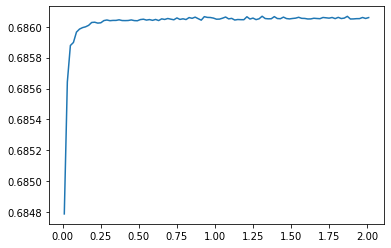

In [357]:
plt.plot(np.linspace(0.01, 2.01, 101), scores)

In [358]:
metamodel.coef_[0]

array([1.52620167, 1.91166173, 3.12181923, 0.40137854])

In [359]:
new_train_df

,cb,lgbm,xgb,bnb
14109,0.124866,0.123943,0.102258,0.248348
18950,0.126170,0.130497,0.126379,0.094639
3675,0.267911,0.269999,0.231292,0.310287
16429,0.279255,0.288998,0.268855,0.205284
13475,0.302361,0.286486,0.266815,0.240296
...,...,...,...,...
28334,0.055209,0.043037,0.047204,0.119137
5861,0.086697,0.092072,0.081122,0.044510
26451,0.160622,0.166365,0.229929,0.196331
2572,0.149404,0.160740,0.150556,0.191951


In [360]:
for col in new_train_df:
    print(col, roc_auc_score(logreg_y_train, new_train_df[col]),  roc_auc_score(logreg_y_valid, new_test_df[col]))

cb 0.6853262391710406 0.6838501379280796
lgbm 0.6850292356616391 0.6839048271532105
xgb 0.6869176295167968 0.6847873732363498
bnb 0.6511381297505183 0.6599939975743115


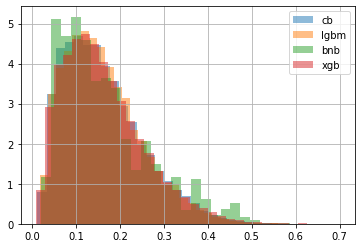

In [364]:
# new_train_df['lr'].hist(alpha=0.5, bins=30, density='uniform', label='lr')
new_train_df['cb'].hist(alpha=0.5, bins=30, density='uniform', label='cb')
new_train_df['lgbm'].hist(alpha=0.5, bins=30, density='uniform', label='lgbm')
new_train_df['bnb'].hist(alpha=0.5, bins=30, density='uniform', label='bnb')
new_train_df['xgb'].hist(alpha=0.5, bins=30, density='uniform', label='xgb')
plt.legend()
plt.show()


In [365]:
skf = StratifiedKFold(n_splits=5, random_state=18, shuffle=True)
cb_scores, cb_result, cb_oof_result = do_cv(
    catboost_train,
    catboost_test,
    catboost_train['def'],
    catboost_columns,
    catboost_cat_features,
    catboost_params,
    skf,
    'catboost'
)

lr_scores, lr_result, lr_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    lr_cols,
    [],
    lr_params,
    skf,
    'logreg',
)

lgbm_scores, lgbm_result, lgbm_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    lgbm_columns,
    lgbm_cat_features,
    lgbm_params,
    skf,
    'lgbm'
)

knn_scores, knn_result, knn_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    knn_columns,
    [],
    knn_params,
    skf,
    'knn'
)

xgb_scores, xgb_result, xgb_oof_result = do_cv(
    lgbm_train,
    lgbm_test,
    lgbm_train['def'],
    xgb_columns,
    [],
    xgb_params,
    skf,
    'xgboost'
)

d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1555: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['home_ownership', 'purpose']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
d:\kaggle\sber_plus_nsu\.venv\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01


In [367]:
nb_scores, nb_result, nb_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    nb_columns,
    [],
    {},
    skf,
    'nb',
)

bnb_scores, bnb_result, bnb_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    bnb_columns,
    [],
    {},
    skf,
    'bnb',
)

rf_scores, rf_result, rf_oof_result = do_cv(
    logreg_train,
    logreg_test,
    logreg_train['def'],
    rf_columns,
    [],
    rf_params,
    skf,
    'rf',
)

In [425]:
new_train_df = pd.DataFrame({
    'lr':lr_oof_result,
    'cb':cb_oof_result,
    'lgbm': lgbm_oof_result,
    'knn': knn_oof_result,
    'xgb': xgb_oof_result,
    'nb': nb_oof_result,
    'bnb': bnb_oof_result,
    'rf': rf_oof_result,
})
new_test_df = pd.DataFrame({
    'lr':lr_result,
    'cb':cb_result,
    'lgbm': lgbm_result,
    'knn': knn_result,
    'xgb': xgb_result,
    'nb': nb_result,
    'bnb': bnb_result,
    'rf': rf_result,
})

In [430]:
lr = LogisticRegression(C=0.1, solver='liblinear')
scores = cross_val_score(lr, new_train_df, logreg_train['def'], cv=5, scoring='roc_auc')

In [431]:
np.mean(scores), np.std(scores)

(0.6878331288719025, 0.008938333458176814)

In [427]:
np.mean(scores), np.std(scores)

(0.6873485107551087, 0.0089311765654575)

In [422]:
lr_f_scores, lr_f_result, lr_f_oof_result = do_cv(
    new_train_df,
    new_test_df,
    logreg_train['def'],
    new_train_df.columns,
    [],
    {},
    skf,
    'logreg',
)

In [423]:
logreg_test['prob'] = lr_f_result

In [424]:
logreg_test[['id', 'prob']].to_csv('blend_v1_eited_submission.csv', index=False)